# Turing Target Practice

## Model

In [1]:
] activate "."

  Activating project at `~/PhD/MCHMC.jl`


In [17]:
# The statistical inference frame-work we will use
using Turing
using ForwardDiff
using LinearAlgebra
using PyPlot

using Revise
using MCHMC

[ Info: Precompiling MCHMC [92da4d09-9da0-4f8a-8b31-da41ef0ab6ee]


In [18]:
fs8_zs = [0.38, 0.51, 0.61, 1.48, 0.44, 0.6, 0.73, 0.6, 0.86, 0.067, 1.4]
fs8_data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482]
fs8_cov = [0.00203355 0.000811829 0.000264615 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.000811829 0.00142289 0.000662824 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 
           0.000264615 0.000662824 0.00118576 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.002025 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0064 0.00257 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.00257 0.003969 0.00254 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.00254 0.005184 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0144 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0121 0.0 0.0; 
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.003025 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.013456000000000001];

In [19]:
function make_fs8(Ωm, σ8; Ωr=8.24*10^-5)
    # ODE solution for growth factor
    x_Dz = LinRange(0, log(1+1100), 300)
    dx_Dz = x_Dz[2]-x_Dz[1]
    z_Dz = @.(exp(x_Dz) - 1)
    a_Dz = @.(1/(1+z_Dz))
    aa = reverse(a_Dz)
    e =  @.(sqrt.(abs(Ωm)*(1+z_Dz)^3+Ωr*(1+z_Dz)^4+(1-Ωm-Ωr)))
    ee = reverse(e)

    dd = zeros(typeof(Ωm), 300)
    yy = zeros(typeof(Ωm), 300)
    dd[1] = aa[1]
    yy[1] = aa[1]^3*ee[end]

    for i in 1:(300-1)
        A0 = -1.5 * Ωm / (aa[i]*ee[i])
        B0 = -1. / (aa[i]^2*ee[i])
        A1 = -1.5 * Ωm / (aa[i+1]*ee[i+1])
        B1 = -1. / (aa[i+1]^2*ee[i+1])
        yy[i+1] = (1+0.5*dx_Dz^2*A0*B0)*yy[i] + 0.5*(A0+A1)*dx_Dz*dd[i]
        dd[i+1] = 0.5*(B0+B1)*dx_Dz*yy[i] + (1+0.5*dx_Dz^2*A0*B0)*dd[i]
    end

    y = reverse(yy)
    d = reverse(dd)

    Dzi = LinearInterpolation(z_Dz, d./d[1], extrapolation_bc=Line())
    fs8zi = LinearInterpolation(z_Dz, -σ8 .* y./ (a_Dz.^2 .*e.*d[1]),
                                 extrapolation_bc=Line())
    return fs8zi
end

make_fs8 (generic function with 1 method)

In [20]:
@model function model(data; cov = fs8_cov) 
    # Define priors
    #KiDS priors
    Ωm ~ Normal(0.3, 0.1)
    σ8 ~ Normal(0.8, 0.3)
    fs8_itp = make_fs8(Ωm, σ8)
    theory = fs8_itp(fs8_zs)
    data ~ MvNormal(theory, cov)
end;

In [21]:
stat_model = model(fs8_data)

DynamicPPL.Model{typeof(model), (:data, :cov), (:cov,), (), Tuple{Vector{Float64}, Matrix{Float64}}, Tuple{Matrix{Float64}}, DynamicPPL.DefaultContext}(model, (data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482], cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001]), (cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001],), DynamicPPL.DefaultContext())

## Sampling

In [34]:
target = TuringTarget(stat_model);

LoadError: UndefVarError: `Line` not defined

In [52]:
mchmc = Sampler(0.0, 0.0, varE_wanted=2.0) #sqrt(target.d)*0.01

Sampler(Settings(Random.MersenneTwister(0), 2.0, 0, 1000, 10, "LF"), Hyperparameters{Float64}(0.0, 0.0, 0.0, 0.1931833275037836), MCHMC.Leapfrog)

In [53]:
samples_mchmc = Sample(mchmc, target, 10000;
                       monitor_energy=true, 
                       dialog=true)

eps: 0.5 --> VarE: NaN
eps: 

[ Info: Tuning eps ⏳


0.25 --> VarE: 116.71193516283375
eps: 0.125 --> VarE: 40.456116755700535
eps: 0.0625 --> VarE: 6.2444831632640465
eps: 0.03125 --> VarE: 2.4978322300705327
eps: 0.015625 --> VarE: 1.000949097377487
samples: 100--> ESS: 0.05805600599553295
samples: 243--> ESS: 0.051153791095190464
eps: 0.015625
L: 0.12218058263501085


[ Info: Found eps ✅
[ Info: Tuning L ⏳
[ Info: Found L ✅


10001-element Vector{Any}:
 [0.25609100737163576, 1.146044280747749, 0.0, -15.17426987483946]
 [0.25609100737163576, 1.146044280747749, -1.8137335311969949, -19.726487130236027]
 [0.2618600281052668, 1.1605652664159098, -1.7264922240022358, -14.898805880717912]
 [0.2510060245298377, 1.1493255497208783, 13.972420203142448, -10.361827354545415]
 [0.2408725980983687, 1.1374320937993219, 13.260001351645304, -6.127445784772087]
 [0.2305118213084826, 1.125736157354977, 12.299888188552925, -2.2052660346275186]
 [0.21914950959149496, 1.1150105572577327, 11.361793953255683, 1.3984679497473205]
 [0.207938549726939, 1.104126853664042, 10.449907019838886, 4.6605726579162345]
 [0.19701302341700896, 1.0929566477639243, 9.374925297406989, 7.554330978865117]
 [0.18644304453458985, 1.0814494251874198, 8.258458847867846, 10.066242305565115]
 [0.17511376941244547, 1.0706889349473443, 7.081053198081804, 12.149488288395453]
 [0.16304678861150043, 1.0607627776168551, 5.7570510616624, 13.774412070304471]
 [0

In [25]:
#plt.plot(samples_mchmc.E[8000:end])

In [26]:
#mean(samples_mchmc.E[8000:end])

In [27]:
#std(samples_mchmc.E[8000:end])^2/target.d

In [56]:
Wms_mchmc = [sample[1] for sample in samples_mchmc]
s8s_mchmc = [sample[2] for sample in samples_mchmc];

LoadError: UndefVarError: `samples_mchmc` not defined

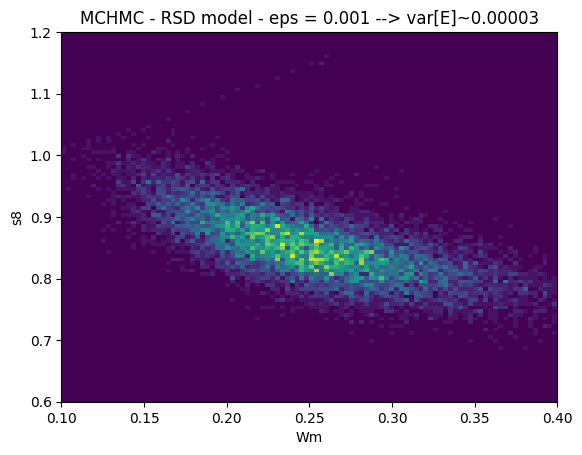

In [57]:
plt.hist2d(Wms_mchmc, s8s_mchmc, bins=100, range=[[0.1, 0.4],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("MCHMC - RSD model - eps = 0.001 --> var[E]~0.00003");

## AbstractMCMC

In [59]:
mchmc = Sampler(0.0, 0.0, varE_wanted=2.0)

Sampler(Settings(Random.MersenneTwister(0), 2.0, 0, 1000, 10, "LF"), Hyperparameters{Float64}(0.0, 0.0, 0.0, 0.1931833275037836), MCHMC.Leapfrog)

In [60]:
samples = sample(
    stat_model, mchmc, 10000;
    monitor_energy=true, 
    dialog=true)

[ Info: Tuning eps ⏳


eps: 0.5 --> VarE: NaN
eps: 0.25 --> VarE: NaN
eps: 0.125 --> VarE: 42.096995054763134
eps: 0.0625 --> VarE: 10.427896634639383
eps: 0.03125 --> VarE: 3.700668748000713
eps: 0.015625 --> VarE: 1.6832313579623042
samples: 100--> ESS: 0.04306936034043441
samples: 243--> ESS: 0.05462510715665329
eps: 0.015625
L: 0.11441625152471223


[ Info: Found eps ✅
[ Info: Tuning L ⏳
[ Info: Found L ✅
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01


Chains MCMC chain (10000×4×1 Array{Float64, 3}):

Iterations        = 1:1:10000
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 3.06 seconds
Compute duration  = 3.06 seconds
parameters        = Ωm, σ8
internals         = E, logp

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat   e ⋯
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64     ⋯

          Ωm    0.2511    0.0581     0.0006    0.0021   635.1874    1.0016     ⋯
          σ8    0.8518    0.0559     0.0006    0.0020   647.8999    1.0022     ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          Ωm    0.1517    0.2095    0.2467    0.2872    0.3761
          σ8    0.7528    0.8149    0.8498    0.8867    0.9633


## NUTS

In [20]:
samples_hmc = sample(stat_model, NUTS(500, 0.65),
                     10000, progress=true; save_state=true)

┌ Info: Found initial step size
└   ϵ = 0.05
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:02


Chains MCMC chain (10000×14×1 Array{Float64, 3}):

Iterations        = 501:1:10500
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 9.68 seconds
Compute duration  = 9.68 seconds
parameters        = Ωm, σ8
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

          Ωm    0.2536    0.0593     0.0006    0.0012   2454.2226    1.0000    ⋯
          σ8    0.8517    0.0545     0.0005    0.0010   2676.2786    1.0000    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

      

In [21]:
samples_hmc.value

3-dimensional AxisArray{Float64,3,...} with axes:
    :iter, 501:1:10500
    :var, [:Ωm, :σ8, :lp, :n_steps, :is_accept, :acceptance_rate, :log_density, :hamiltonian_energy, :hamiltonian_energy_error, :max_hamiltonian_energy_error, :tree_depth, :numerical_error, :step_size, :nom_step_size]
    :chain, 1:1
And data, a 10000×14×1 Array{Float64, 3}:
[:, :, 1] =
 0.356897  0.754874  16.7982  3.0  1.0  …  2.0  0.0  0.731089  0.731089
 0.386638  0.763995  16.5036  3.0  1.0     2.0  0.0  0.731089  0.731089
 0.398764  0.788632  16.2518  3.0  1.0     2.0  0.0  0.731089  0.731089
 0.181248  0.851034  17.3564  7.0  1.0     2.0  0.0  0.731089  0.731089
 0.202002  0.847555  18.2107  1.0  1.0     1.0  0.0  0.731089  0.731089
 0.27528   0.837888  18.7557  3.0  1.0  …  2.0  0.0  0.731089  0.731089
 0.276317  0.839473  18.7347  3.0  1.0     2.0  0.0  0.731089  0.731089
 0.312922  0.816106  18.2917  3.0  1.0     2.0  0.0  0.731089  0.731089
 0.323827  0.818671  18.0568  1.0  1.0     1.0  0.0  0.731089  

In [22]:
Wms_hmc = vec(samples_hmc["Ωm"])
s8s_hmc = vec(samples_hmc["σ8"]);

LoadError: UndefVarError: `Wms_hmc` not defined

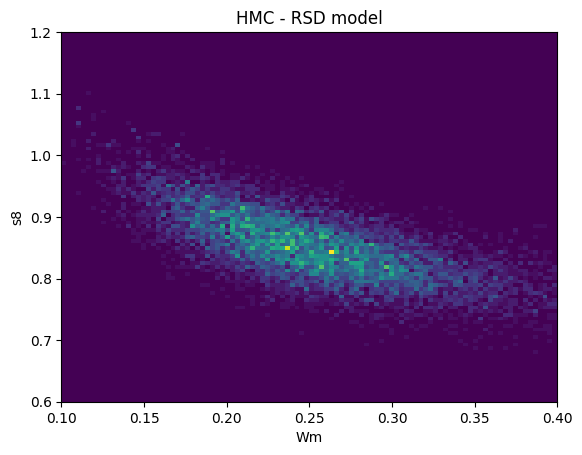

In [23]:
plt.hist2d(Wms_hmc, s8s_hmc, bins=100, range=[[0.1, 0.4],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("HMC - RSD model");